# 作業 1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個 CNN 模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案 -> 在雲端硬碟建立副本。

**第二步驟**: 右上角 共用 -> 取得連結 -> 任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段 -> 更變執行類型 -> GPU。可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個 colab 的程式來完成訓練 CNN 模型。**只要跑得出來 Testing Accuracy、Loss; 1~7 個作業項目即可**，不必一定要照著 todo 提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的 label 不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label 隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看 test data
2. 模型請手刻、手疊，**不要用 Transfer Learning** 來引入 ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存 output 結果，更改**檔名學號**，左上角 檔案 -> 下載 -> 下載.ipynb檔。
2. 交一個 pdf 檔，裡面需要附上**你的作業 colab 連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的 Test Acc
4. 上述兩個檔案繳交至 ee-class。

> **算分標準**

20 + Test_Acc + Predict function(10 分) + 20 分文件
1. 20 分免費送
2. Test_Acc (1 分/1%)
3. predict_author 有寫出來就 10 分(第七段)
4. 20 分是文件分數
    - 姓名、學號、年級
    - colab 連結
    - Test accuracy
    - 撰寫過程與截圖
    - 心得

有問題再來信助教: lexlie.yunglinchu@gmail.com

### 資料集下載

- 資料集說明 : 
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊 colab 左側**檔案**來查看

- 下載連結：
  - train: https://drive.google.com/file/d/1K3FRVeabwV7TxboRsrkFcT34tPV9DWqr/view?usp=sharing
  - test: https://drive.google.com/file/d/1GCzWxFrIbb4d1JSXSrt3kRb6uERVqXpx/view?usp=sharing


In [ ]:
import random
import os

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免 IP 被封鎖

if not os.path.isfile("./train.zip"):
    !gdown --id '10Vqy1ZfHDIaUXcZ24rrnLGQguZcluwR7'  # train.zip
    !gdown --id '1G1dV8-lIJHnEZvyVE486St8FPbK_mMnZ'  # test.zip
    !unzip train.zip
    !unzip test.zip
else:
    !echo "檔案已存在"

## 1. 讀入封包

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

## 2. 取得資料集

- **我們來檢視一下 artist.csv**，重要內容包含:
  - 畫家名稱 (name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有 50 位畫家，意謂著有 50 個 class 要去辨識。

In [3]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ", num_classes)
artists.head()

* 只取出名字與畫的數量，把名字用下底線連起來

In [ ]:
artists = artists.loc[:, ["name", "paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
print(artists['name'])
artists.head()

* **計算各個畫家畫作數量**
* 每個 class 資料的不平衡容易影響模型的訓練，學生可以嘗試解決這個問題。(提示: keras 的 class_weight)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(artists.name, artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)

print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ", artists.paintings.max(), " 最少畫作為 : ", artists.paintings.min())

* 隨機讀取畫作來看看

In [4]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
random_list = random.sample(range(0, total_len), 20)
print("training 畫作總共畫作有 : ", total_len)

show_imgs = [img_list[rand] for rand in random_list]

plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = os.path.join('train_augmented', imgName)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

# 2.1 Data Augmentation(無使用)

In [ ]:
# from PIL import Image
# import numpy as np
# import uuid
# import shutil

# if os.path.exists('train_augmented'):
#     shutil.rmtree('train_augmented')
# else:
#     os.makedirs('train_augmented')

# # Open the image file
# index = 0
# MUL = 1

# for img_name in os.listdir('train_resized'):
#   img = Image.open(os.path.join('train_resized', img_name))

#   # Randomly flip the image horizontally
#   for i in range(MUL):
#     if np.random.rand() < 0.5:
#         img = img.transpose(Image.FLIP_LEFT_RIGHT)

#   # Randomly flip the image vertically
#     if np.random.rand() < 0.5:
#         img = img.transpose(Image.FLIP_TOP_BOTTOM)

#     # Define the zoom factor
#     zoom_factor = random.randint(1, 10)

#     # Compute the new size of the image
#     new_size = (int(img.size[0] / zoom_factor), int(img.size[1] / zoom_factor))

#     # Compute the top-left corner of the zoomed region
#     x0 = int((img.size[0] - new_size[0]) / 2)
#     y0 = int((img.size[1] - new_size[1]) / 2)

#     # Crop the zoomed region
#     zoomed_region = img.crop((x0, y0, x0 + new_size[0], y0 + new_size[1]))

#     # Resize the zoomed region to the original size
#     zoomed_img = zoomed_region.resize(img.size)

#     # generate file name
#     output_name = '_'.join(img_name.split('_')[:-1]) + '_' + str(uuid.uuid4()) + '.jpg'

#     zoomed_img.save(os.path.join('train_augmented', output_name))

#     percentage = 100*(MUL*index+1)/MUL/len(img_list)
#     formated_percentage = "{:.2f}".format(percentage)
#     print(f'{output_name} image is stored, {formated_percentage}% is done')
#   index += 1



## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出 label : Claude_Monet
2. label (作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label 數字還要轉成 50 depth 的 one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到 [0,1] 之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料 input output 的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入 tensor 後用 map 將路徑轉成圖片檔案。

* **以下程式 todo 只是提供程式思路，你完全可以不理他，反正 test 結果能出來就好。**

In [5]:
# 請建立將英文映射成數字的 dict。EX: Van_Gogh --> 0
def make_author_dict():
    ##########
    # todo #
    ##########
    authors_dic = dict()

    artists = pd.read_csv("./artists.csv")
    author_names = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))

    for author, i in enumerate(author_names):
        authors_dic[i] = author

    return authors_dic


class_name = make_author_dict()

# 請建立將數字映射成英文的 dict。 EX: 0 --> Van_Gogh
rev_class_name = {value : key for key, value in class_name.items()}

# 3.1 設定Class Weight

In [6]:
# assigning class weight

artists = pd.read_csv("./artists.csv")

artists['class_weight'] = artists.paintings.sum() / (artists.shape[0] * artists.paintings)
class_weight = artists['class_weight'].to_dict()

In [7]:
def get_label(pic_name):
    # 請取出 label 並轉成數字
    # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
    ##########
    # todo #
    author_name = '_'.join(pic_name.split('_')[:-1])
                           
    ##########
    return class_name[author_name]


def get_path(dir, pic_name):
    # 請將路徑合併
    # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
    ##########
    # todo #
    ##########
    return os.path.join(dir, pic_name)


def make_paths_label(dir):
    img_list = os.listdir(dir)
    paths = []
    labels = []

    # 將preprocess完成的 path、label 用 for 迴圈放入 paths 和 labels
    ##########
    # todo #
    for img in img_list:
        paths.append(get_path(dir, img))
        labels.append(get_label(img))
    ##########
    # 將 labels 轉成 onehot
    # todo
    onehot_labels = to_categorical(labels).astype(int)
    
    return paths, onehot_labels

In [ ]:
來查看一下
paths, onehot_labels = make_paths_label(train_dir)
print(paths[0])
print(onehot_labels[0])
print("paths : ")
for p in paths[:5]:
    print(p)
print("-" * 20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)
for i in range(50):
    author_name = '_'.join((paths[i].split('/')[-1][:-4]).split('_')[:-1])
    if rev_class_name[class_name[author_name]] == author_name:
        print(True, i) 


* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [ ]:
# 轉成 tensorflow dataset 格式，變成路徑 tensor
# 這個只是 from_tensor_slices 範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
    print(tensor)

In [9]:
# 決定你輸入模型的圖片長寬
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SIZE = [256, 256]
# shuffle buffer size
SHUFFLE_BUFFER = 5000


def get_image(path):
    # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file, channels=3)
    img = tf.cast(img, tf.float32)/255

    # 請固定每張圖片大小為 IMG_HEIGHT、IMG_WIDTH
    # 並將圖片每個 pixel 映射到 [0,1] 之間
    ##########
    # todo 
    resized_img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    ##########
    return resized_img


# 將所有資料轉成 Tensor -> Tensor 轉成圖片
# 圖片 Tensor 與 label Tensor Zip 起來成一個 pair
# shuffle 打散
def make_dataset(dir):
    paths, onehot_labels = make_paths_label(dir)

    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

    # 將路徑 tensor 映射成圖片 tensor
    train_image = paths_ds.map(get_image)
    # 合併圖片與 label 資料集
    full_ds = tf.data.Dataset.zip((train_image, train_label))
    # 打散
    full_ds = full_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
    return full_ds


full_ds = make_dataset(train_dir)

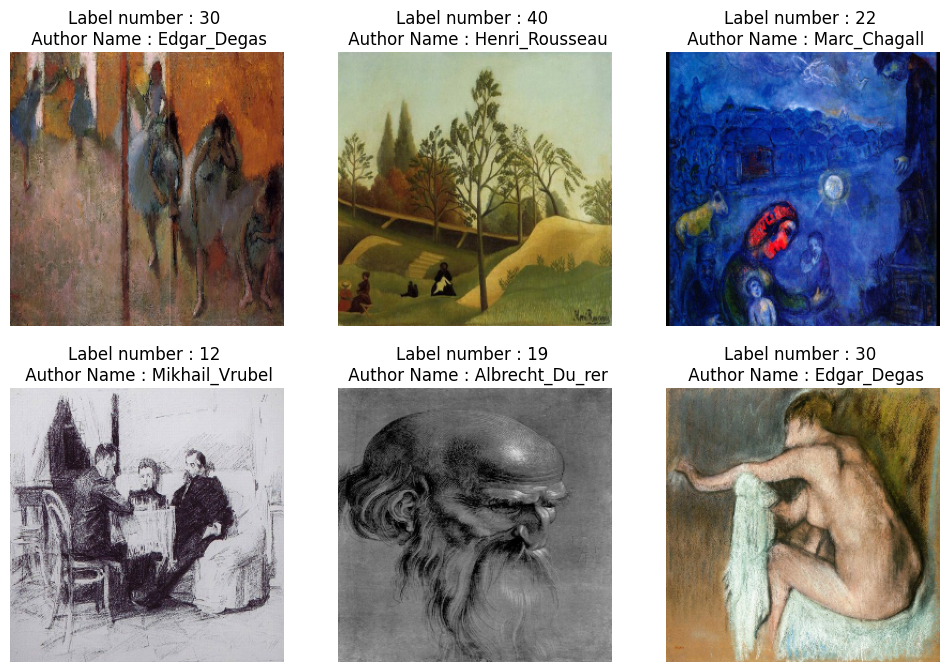

In [ ]:
# # 取出 Tensor 圖片來看看
plt.figure(figsize=(12, 8))
for index, (img, label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2, 3, index + 1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(l, rev_class_name[l]))
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [12]:
# 切割成 training data 與 validation data
train_len = int(0.8 * total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ", train_len, " val size : ", val_len)

# 添加 batch
# todo
BATCH_SIZE = 16

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train size :  6016  val size :  1504


In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x, y = trainiter.next()
print("training image batch shape : ", x.shape)
print("training label batch shape : ", y.shape)

training image batch shape :  (32, 256, 256, 3)
training label batch shape :  (32, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做 fine-tuning，**請自己手動建**。

In [13]:
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D,
                                     BatchNormalization, 
                                     GlobalAveragePooling2D,
                                     Dense, 
                                     Dropout)
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(64, 3, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(50, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                        

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import *
# todo
EPOCHS = 100

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
##########
# todo #
##########
# model.compile 決定 learning strategy、Loss calculator
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience = 50, 
                               verbose = 2, 
                               restore_best_weights = True)

history = model.fit(train_ds,  
                    epochs=EPOCHS, 
                    validation_data=val_ds, 
                    callbacks=early_stopping, 
                    class_weight=dict(enumerate(class_weight)))

Epoch 1/100
376/376 [==============================] - 100s 169ms/step - loss: 81.5681 - accuracy: 0.1295 - val_loss: 4.4574 - val_accuracy: 0.1124
Epoch 2/100
376/376 [==============================] - 73s 153ms/step - loss: 72.1211 - accuracy: 0.1760 - val_loss: 3.0459 - val_accuracy: 0.2620
Epoch 3/100
376/376 [==============================] - 74s 154ms/step - loss: 67.8907 - accuracy: 0.1946 - val_loss: 2.9269 - val_accuracy: 0.3052
Epoch 4/100
376/376 [==============================] - 73s 153ms/step - loss: 64.5576 - accuracy: 0.2123 - val_loss: 3.0563 - val_accuracy: 0.2779
Epoch 5/100
376/376 [==============================] - 73s 153ms/step - loss: 60.9683 - accuracy: 0.2435 - val_loss: 2.7987 - val_accuracy: 0.3152
Epoch 6/100
376/376 [==============================] - 88s 193ms/step - loss: 59.5782 - accuracy: 0.2435 - val_loss: 3.0453 - val_accuracy: 0.2773
Epoch 7/100
376/376 [==============================] - 87s 192ms/step - loss: 57.3663 - accuracy: 0.2601 - val_loss: 

In [15]:
from keras.models import load_model
# save the model

model.save("painting_classification.h5")

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


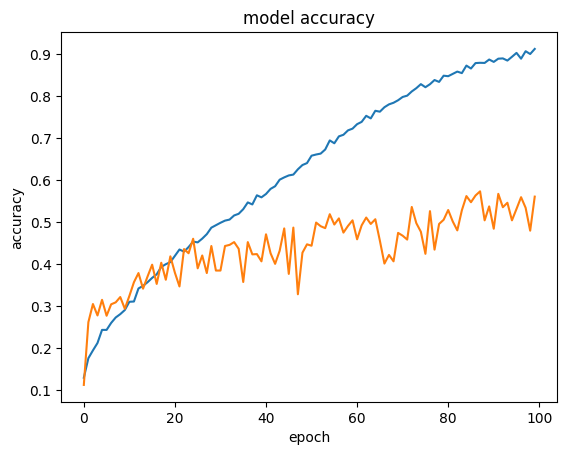

In [16]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

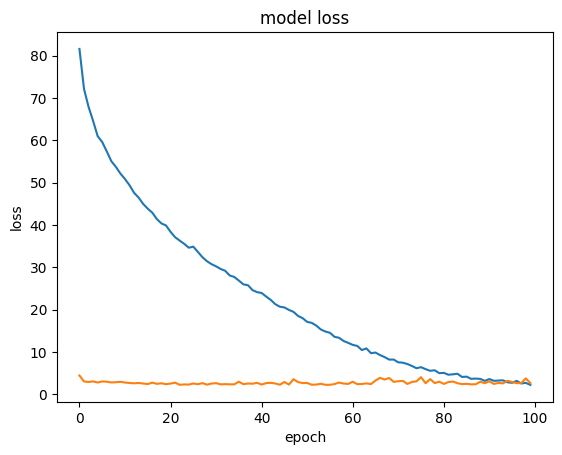

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

In [18]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(BATCH_SIZE)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

53/53 [==============================] - 6s 35ms/step - loss: 2.9565 - accuracy: 0.5138
Test loss: 2.956494092941284
Test accuracy: 0.5137724280357361


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入 Model 做預測

In [ ]:
def predict_author(img):
    # 寫個單圖片模型預測 function
    # input : opencv img (height,width,3)
    # output : 某個作家名字 E.g. Claude_Monet

    author_name = ""
    ##########
    # todo #
    ##########

    img = np.expand_dims(img, axis=0)    # 1. expand img dimension (height,width,3) -> (1,height,width,3)

    output = model.predict(img)          # 2. 丟入模型 model.predict

    author_class = np.argmax(output)     # 3. 取出 softmax 後 (50,) 取最大值的 index 作為辨識結果

    author_name += rev_class_name[author_class]    # 4. 將辨識結果轉為畫作家名字

    return author_name

1/1 [==============================] - 0s 21ms/step


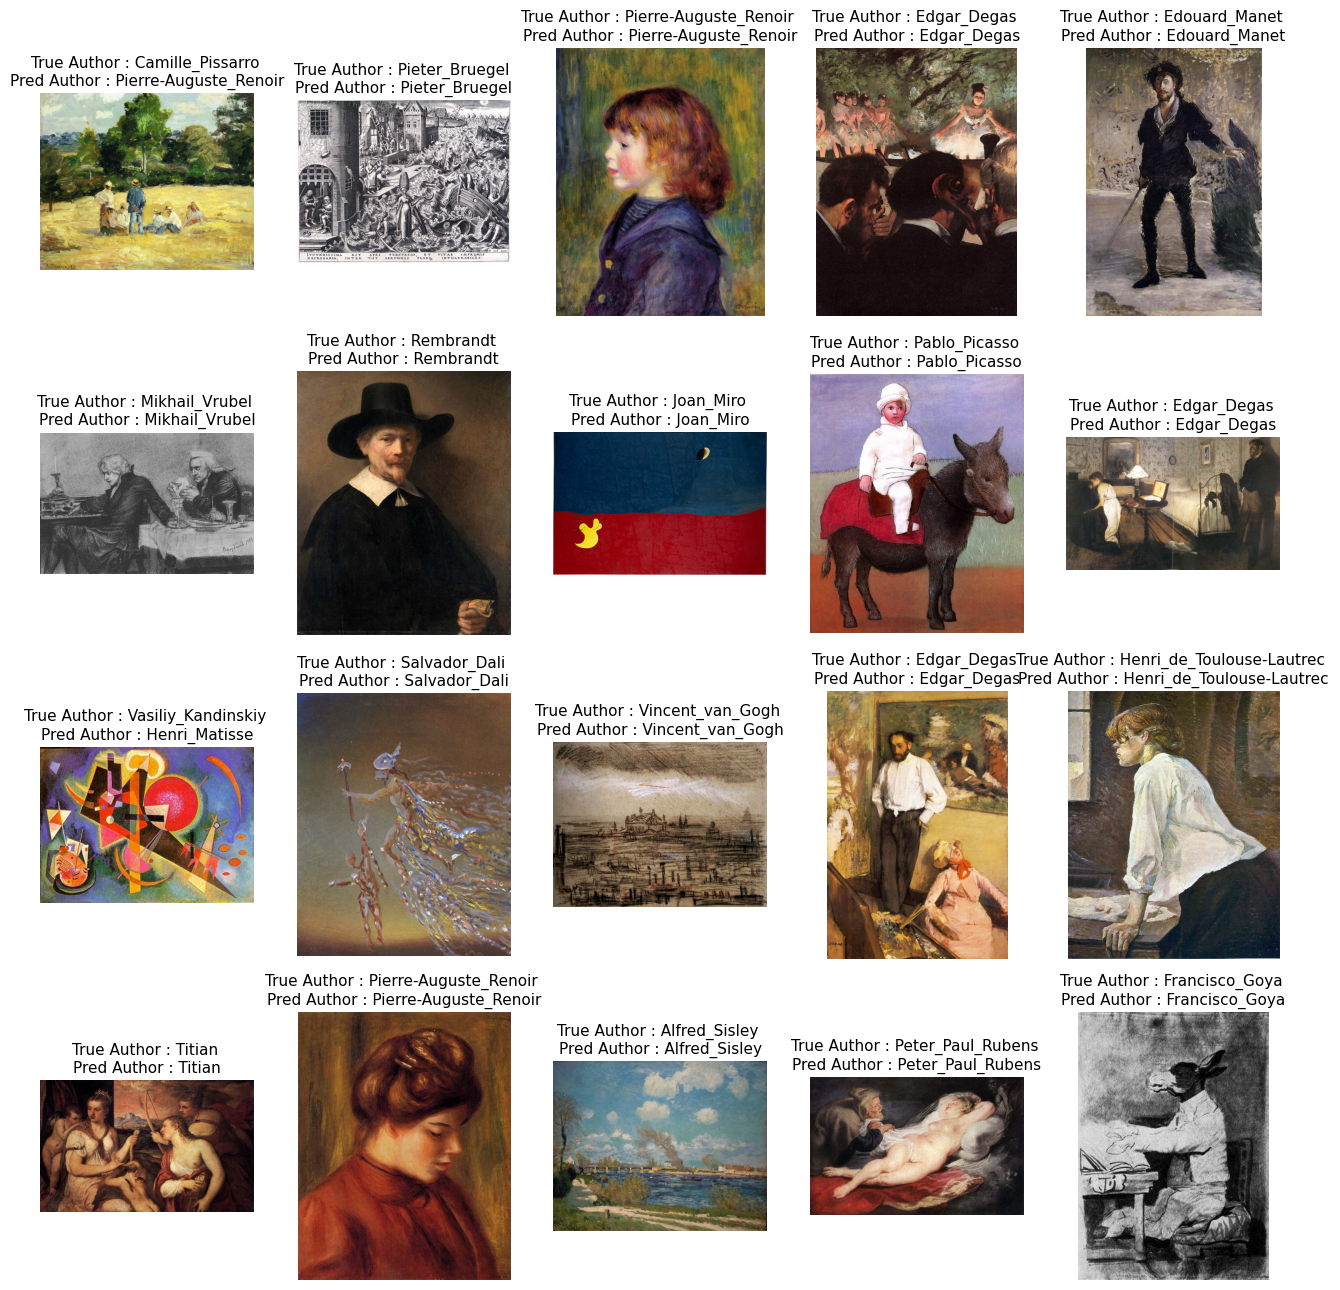

In [ ]:
random_list = random.sample(range(0, total_len), 20)
show_imgs = [img_list[rand] for rand in random_list]

plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.axis("off")
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    plt.title(
        "True Author : {} \nPred Author : {}".format(
            "_".join(imgName.split("_")[:-1]), predict_author(img)
        ),
        size=11,
    )

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [ ]:
from google.colab import files


def upload_img():
    uploaded = files.upload()
    img_name = list(uploaded.keys())[0]
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img


def eval():
    img = upload_img()
    plt.title("predict author : {}".format(predict_author(img)))
    plt.axis("off")
    plt.show()

Saving IMG_3570.jpg to IMG_3570.jpg
1/1 [==============================] - 0s 88ms/step


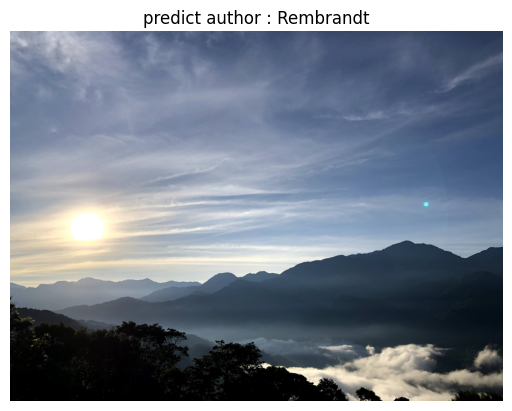

In [ ]:
# 自己上傳一張圖片來試試看
# Demo 圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()